---
title: Bloch-Redfield and Redfield Failing for degenerate Hamiltonians
date: 2024-08-08
authors:
  - name: Gerardo Suarez
---

### In The SYK model:

In this section we consider the SYK model whose Hamiltonian is given by ([Ryu paper](https://arxiv.org/pdf/2112.13489), [introduction](https://arxiv.org/pdf/2002.12187))

$$H= \sum_{i<j<k<l=1}^{N} J_{i,j,k,l}\psi_{i} \psi_{j} \psi_{k} \psi_{l} $$

Where $J_{i,j,k,l}$ is drawn randomly from a Gaussian ensemble with mean $\mu=0$ and variance $\sigma=\sqrt{3!} \frac{J}{N^{3/2}}$
where J is a constant with dimension of mass. And the $\psi_{i}$ denote the operators of the majorana fermions which are representations
of the clifford algebra. They satisfy

\begin{equation}
\{\psi_{i},\psi_{j}\} = \delta_{i,j}
\end{equation}

For convenience people usually just consider the even case and one dimensional majorana fermions ([appendix A](https://arxiv.org/pdf/2002.12187)). 
We introduce the new basis


$$c_{i}= \frac{1}{\sqrt{2}} (\psi_{2i}-i \psi_{2i+1})$$

$$c_{i}^{\dagger}= \frac{1}{\sqrt{2}} (\psi_{2i}+i \psi_{2i+1})$$

These satisfy

$$\{C_{i},C^{\dagger}_{j}\} = \delta_{i,j}$$
$$\{C_{i}^{\dagger},C_{j}^{\dagger}\} = 0$$

To construct this basis we consider picking a vacuum annhilated by all modes such that 

$$(C_{1}^{\dagger})^{n_{1}} \dots (C_{k}^{\dagger})^{n_{k}} \ket{0 \dots 0} = 0$$

There are $2^{N/2}= 2^{K}$ such states. This is the only irreducible representation of @eq:anti , upn top unitary equailvalence, the representation is given by $2^{k}$ matriceswhich can be found by the recursion relaton

\begin{align}
\psi_{i}^{K} = \psi_{i}^{k-1} \otimes \begin{pmatrix}-1 & 0 \\ 0 &1 \end{pmatrix} \quad \text{for} \quad i=1,2,\dots,N-2 \\
\psi_{N-1}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & 1 \\ 1 &0 \end{pmatrix} \\
\psi_{N}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & -i \\ i &0 \end{pmatrix} 
\end{align}

The superscript $K$ is omitted in the Hamiltonian for convenience. Though not a great example, Let us use $N=2$. To illustrate how solving by Bloch-Redfield may fail

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,52))
k=7
H,psis=syk_full(N,seed=seeds[k])

The Hamiltonian in this example is then given  by

In [3]:
H=20*H #energy rescaling
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-2.18176916  0.          0.          0.        ]
 [ 0.          2.18176916  0.          0.        ]
 [ 0.          0.          2.18176916  0.        ]
 [ 0.          0.          0.         -2.18176916]]

While the coupling operator to the bath is simply 

$Q= \sum_{i} a_{i} \psi_{i}$

Where each $a_{i}$ is a real number

In [4]:
Q=sum([(1/2 +1/(2*i+2))*psis[i] for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.        +0.j          0.53033009-0.70710678j  0.44194174-0.47140452j
   0.        +0.j        ]
 [ 0.53033009+0.70710678j  0.        +0.j          0.        +0.j
  -0.44194174+0.47140452j]
 [ 0.44194174+0.47140452j  0.        +0.j          0.        +0.j
   0.53033009-0.70710678j]
 [ 0.        +0.j         -0.44194174-0.47140452j  0.53033009+0.70710678j
   0.        +0.j        ]]

We consider the initial state to be 

In [5]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)

In [6]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
gamma=w0/2.05
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)

And consider an underdamped spectral density at zero temperature with $\gamma=${eval}`gamma` , $\lambda=${eval}`lam` ,$\omega_{0}=${eval}`w0`. After fitting the correlation function one obtains

In [7]:
from qutip.core import UnderDampedEnvironment
from qutip.solver.heom import BosonicBath

In [8]:
bath =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=2,target_rsme=None)
bath=BosonicBath.from_environment(env,Q)
# cfiitter2 = heom.CorrelationFitter(
#     Q, 0, tfit, bath.correlation_function)
# bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 5.17e-01 |-1.20e+00 |4.64e+00                           | 1         |-5.00e-01 |-1.17e+00 |4.65e+00                            
 2         |-9.20e-02 |-4.39e+00 |1.65e-17                           |                                                                      
                                                                     |A normalized RMSE of  2.38e-06 was obtained for the the i

In [9]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

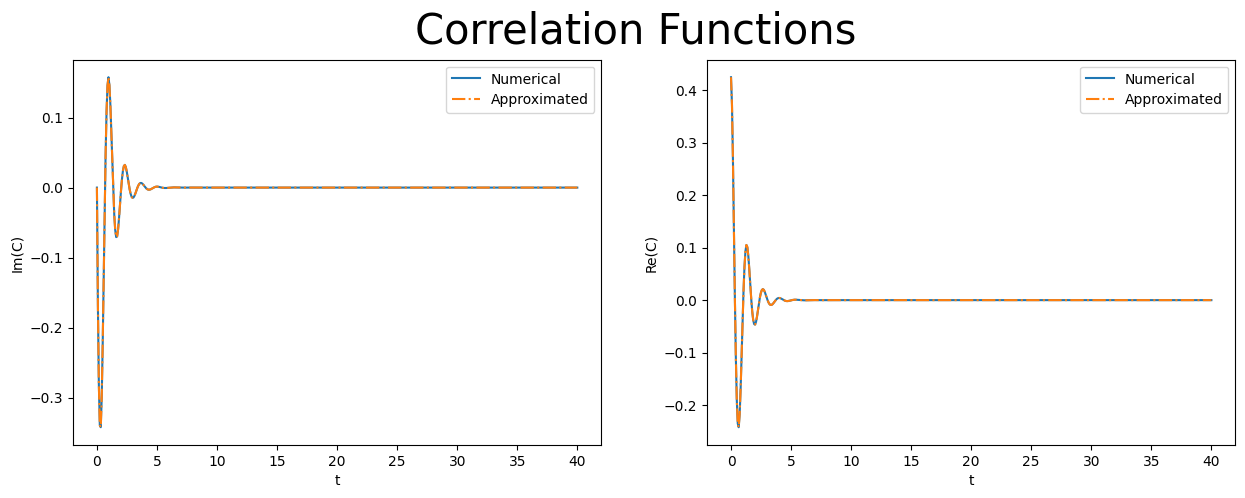

In [10]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath.correlation_function(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath.correlation_function(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [11]:
def solve_dynamics(H,Q,bath,bath1,rho0,depth=7,levels=3,modes=2,times=times):
    print("============================")
    print("Solving HEOM")
    print("============================")
    solver = heom.HEOMSolver(H,
                          [bath1], max_depth=depth, options={"atol": 1e-14})
    result = solver.run(rho0, times)
    print("============================")
    print("HEOM Done")
    print("============================")
    print("============================")
    print("Solving Cumulant")
    print("============================")
    bath.bose=None
    cum = csolve(
        Hsys=H, t=times, baths=[bath],
        Qs=[Q],
        eps=1e-6, cython=False)
    
    result_cum = cum.evolution(rho0)
    
    result_cum = rotation(result_cum, H, times)
    print("============================")
    print("Cumulant Done")
    print("============================")
    print("============================")
    # print("Solving Redfield")
    # print("============================")
    # red=redfield.redfield(Hsys=H, t=times, baths=[bath1],
    # Qs=[Q],
    # eps=1e-12)
    # result_red = red.evolution(rho0)
    # result_red = [Qobj(i) for i in result_red]
    # for i in result_red:
    #     i.dims=H.dims
    # result_red = rotation(result_red, H, times)
    # print("============================")
    # print("Redfield Done")
    print("============================")
    print("============================")
    print("Solving Bloch-Redfield")
    print("============================")
    a_ops = [[Q, lambda w: bath.power_spectrum(w).item()]]
    resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
        "rtol": 1e-14}, sec_cutoff=-1)
    
    print("============================")
    print("Bloch-Redfield Done")
    print("============================")
    print("============================")
    print("Solving Global")
    print("============================")
    global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
    c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
    for i in range(len(c_ops2)):
        c_ops2[i].dims=H.dims 
    result_lindblad_global2 = mesolve(H, rho0, times, c_ops2)
    print("============================")
    print("Global Done")
    print("============================")
    # print("============================")
    # print("Solving Pseudomodes")
    # print("============================")
    # Ncutoff=levels
    # bathu = zero_temp_bath(tfit, lam, gamma, w0, N=modes)
    # print(bathu.fitinfo["summary"])
    # example = pseudomode(Hsys=H, Q=Q, bath=bathu)
    # ans = example.evolution(rho0, Ncutoff, times, options={
    #                     "atol": 1e-14, "normalize_output": False, "store_states": True})
    # ans = [i.ptrace(range(N))for i in ans.states]
    # print("============================")
    # print("Pseudomodes done")
    # print("============================")
    results=[result,result_cum,resultBR,result_lindblad_global2]
    return results

In [12]:
results_syk=solve_dynamics(H,Q,bath,bath,rho0)

Solving HEOM


10.1%. Run time:   3.35s. Est. time left: 00:00:00:29
20.2%. Run time:   5.75s. Est. time left: 00:00:00:22
30.3%. Run time:   8.83s. Est. time left: 00:00:00:20
40.4%. Run time:  11.63s. Est. time left: 00:00:00:17
50.5%. Run time:  13.88s. Est. time left: 00:00:00:13
60.6%. Run time:  16.35s. Est. time left: 00:00:00:10
70.7%. Run time:  19.74s. Est. time left: 00:00:00:08
80.8%. Run time:  22.48s. Est. time left: 00:00:00:05
90.9%. Run time:  25.16s. Est. time left: 00:00:00:02
100.0%. Run time:  27.77s. Est. time left: 00:00:00:00


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Total run time:  27.77s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 264.76it/s]


Cumulant Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


In [13]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


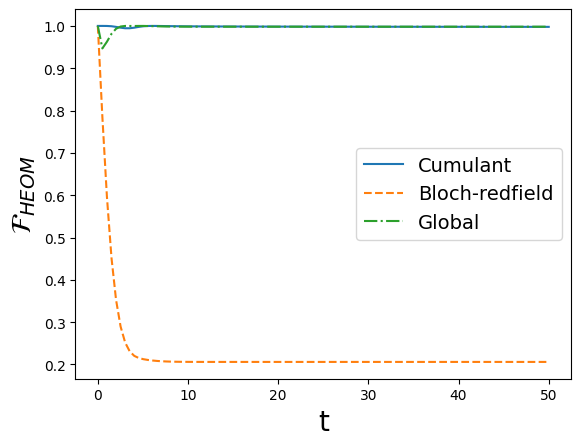

In [14]:
plot_fidelities(results_syk,H,times)

In [15]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$1-TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

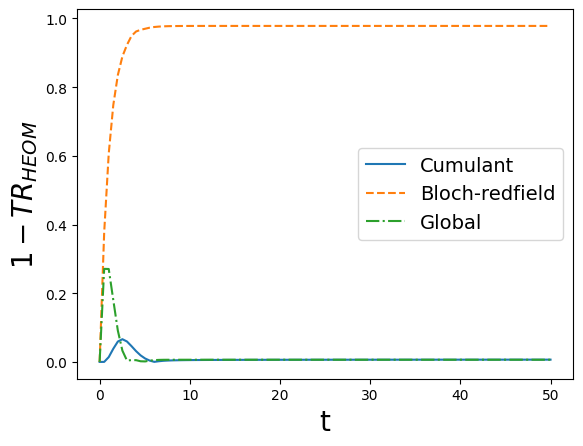

In [16]:
trd(results_syk,H,times)

From what we see in both the trace distance and fidelity plots, the Bloch-Redfield approach does terribly when we consider this scenario (multiple implementations where checked). Notice that this issue seems to be about the coupling operator, rather than the Hamiltonian. Consider a different coupling operator just the majorana fermion denoted by the index 0 coupled to the environment

In [17]:
Q2=psis[0]
Q2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j         0.-0.70710678j 0.+0.j         0.+0.j        ]
 [0.+0.70710678j 0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.-0.70710678j]
 [0.+0.j         0.+0.j         0.+0.70710678j 0.+0.j        ]]

In [18]:
bath = UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=2,target_rsme=None)
bath=BosonicBath.from_environment(env,Q2)

# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 5.17e-01 |-1.20e+00 |4.64e+00                           | 1         |-5.00e-01 |-1.17e+00 |4.65e+00                            
 2         |-9.20e-02 |-4.39e+00 |1.65e-17                           |                                                                      
                                                                     |A normalized RMSE of  2.38e-06 was obtained for the the i

In [19]:
results_syk2=solve_dynamics(H,Q2,bath,bath,rho0,modes=3)

Solving HEOM
10.1%. Run time:   0.91s. Est. time left: 00:00:00:08
20.2%. Run time:   1.78s. Est. time left: 00:00:00:07
30.3%. Run time:   2.61s. Est. time left: 00:00:00:06
40.4%. Run time:   3.46s. Est. time left: 00:00:00:05
50.5%. Run time:   4.32s. Est. time left: 00:00:00:04
60.6%. Run time:   5.40s. Est. time left: 00:00:00:03
70.7%. Run time:   6.29s. Est. time left: 00:00:00:02
80.8%. Run time:   7.18s. Est. time left: 00:00:00:01
90.9%. Run time:   8.13s. Est. time left: 00:00:00:00
100.0%. Run time:   8.93s. Est. time left: 00:00:00:00
Total run time:   8.93s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 416.50it/s]


Cumulant Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


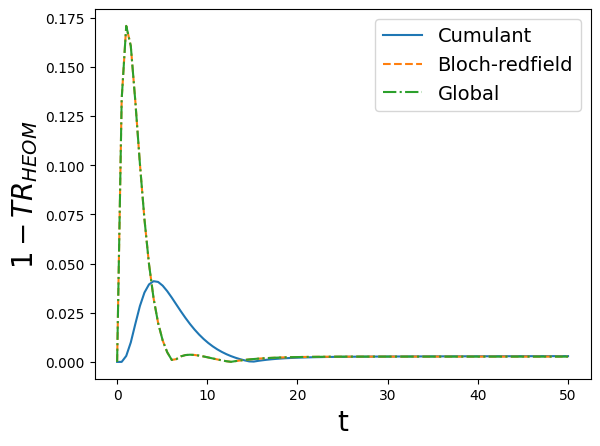

In [20]:
trd(results_syk2,H,times)

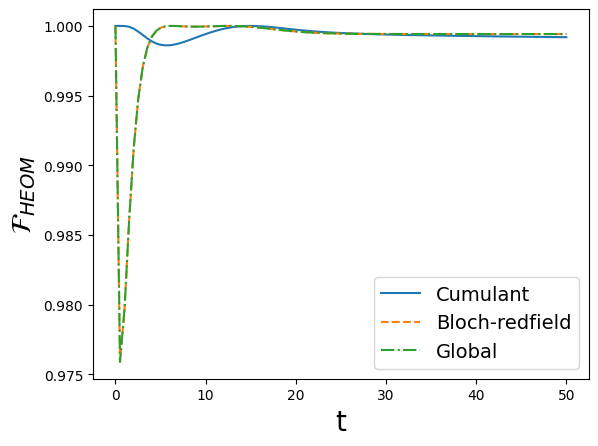

In [21]:
plot_fidelities(results_syk2,H,times)

:::{tip}

Whenever pseudomodes don't work it mainly can be fix with a more delicate fit (usually increasing levels is not worthwile pursuing in this regime)
:::

In [22]:
from qutip import qsave,qload

In [23]:
#qsave(results,f"N={N}_syk_{lam}_nocheating_seed_{seeds[k]}")

##### We can observe the same behaviour in the ising model when the N is large

I should run this example for longer times, so that I can make sure is analogous to the previous case and not just being better in the transient regime  (which would still be good) but along the lines of what was claimed in [This paper](https://arxiv.org/pdf/1806.09181). Than when the cutoff frequency is large bloch redfield does not capture time dependent redfield (I should Also add redfield here and see if the cumulant can do better)

In [24]:
from hamiltonians import ising
H,sx,sy,sz=ising(N=3,g=1,Jx=5)
Q=sx[-1]+ 1.1*sy[-1]+0.9*sz[-1]

In [25]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
gamma=w0/2.05
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)

And consider an underdamped spectral density at zero temperature with $\gamma=${eval}`gamma` , $\lambda=${eval}`lam` ,$\omega_{0}=${eval}`w0`. After fitting the correlation function one obtains

In [26]:
env=UnderDampedEnvironment(lam=lam,gamma=gamma,T=0,w0=w0)
bath,fit2info = env.approx_by_cf_fit(tfit,Nr_max=3,Ni_max=1)
bath =BosonicBath.from_environment(bath,Q)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 5.18e-01 |-2.55e+00 |9.89e+00                           | 1         |-5.00e-01 |-2.49e+00 |9.91e+00                            
 2         |-9.49e-02 |-9.59e+00 |4.50e-09                           |                                                                      
                                                                     |A normalized RMSE of  1.62e-06 was obtained for the the i

In [27]:
times2 = np.linspace(0,40,500)


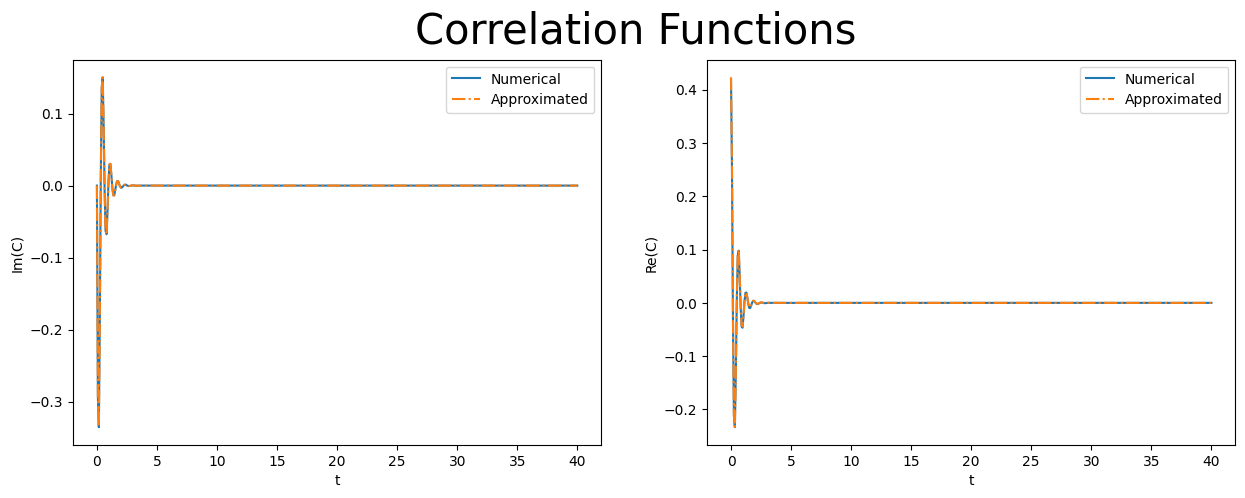

In [28]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(env.correlation_function(times2)),label="Numerical")
axs[0].plot(times2, np.imag(bath.correlation_function(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(env.correlation_function(times2)),label="Numerical")
axs[1].plot(times2, np.real(bath.correlation_function(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [29]:
N=3
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()

In [30]:
example_ising=solve_dynamics(H,Q,env,bath,rho0,modes=1,depth=5,times=np.linspace(0,200,50))

Solving HEOM
10.2%. Run time:  18.14s. Est. time left: 00:00:02:39
20.4%. Run time:  39.27s. Est. time left: 00:00:02:33
30.6%. Run time:  60.62s. Est. time left: 00:00:02:17
40.8%. Run time:  80.96s. Est. time left: 00:00:01:57
51.0%. Run time: 102.22s. Est. time left: 00:00:01:38
61.2%. Run time: 122.78s. Est. time left: 00:00:01:17
71.4%. Run time: 142.69s. Est. time left: 00:00:00:57
81.6%. Run time: 162.28s. Est. time left: 00:00:00:36
91.8%. Run time: 183.09s. Est. time left: 00:00:00:16
100.0%. Run time: 198.48s. Est. time left: 00:00:00:00
Total run time: 198.48s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]


Cumulant Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


In [33]:
plot_fidelities(example_ising,H,times)

IndexError: list index out of range

In [34]:
trd(example_ising,H,times)

IndexError: list index out of range

In [35]:
def plot_populations(states,l=3,m=3):
    times=states[0].times
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([j[l,m] for j in i.states])
        except:
            sdd=np.array([j[l,m] for j in i])
 
        plt.plot(times,sdd,label=labels[k])
    plt.legend(fontsize=14)
    plt.ylabel(rf"$\rho_{l,m}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


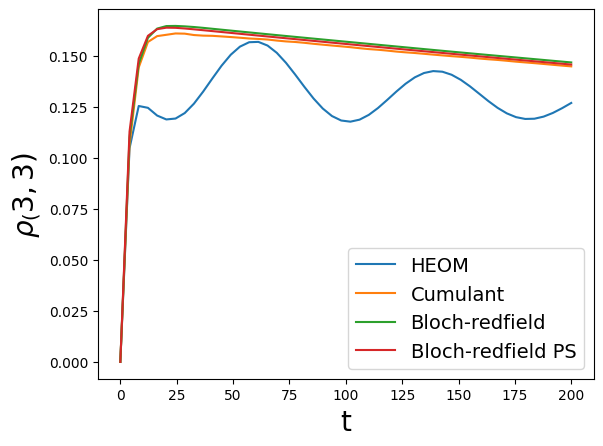

In [36]:
plot_populations(example_ising)